In [78]:
import math as Math

class Scalar:
    def __init__(self, data, grad = 0, op ='', deps = (), label = ''):
        self.data = data
        self.grad = grad
        self._op = op
        self._deps = set(deps)
        self.label = label
        self._backprop = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data + other.data, op = '+', deps = (self, other))
        def backprop():
            self.grad += out.grad
            other.grad += out.grad
        out._backprop = backprop
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, op = '*', deps = (self, other))
        def backprop():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backprop = backprop
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/floats as exponent"
        out = Scalar(self.data ** other, op = '**', deps = (self,))
        def backprop():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backprop = backprop
        return out
    def exp(self):
        out = Scalar(Math.e ** self.data, op = 'exp', deps = (self,))
        def backprop():
            self.grad += out.data * out.grad
        out._backprop = backprop
        return out
    def log10(self):
        out = Scalar(Math.log10(self.data), op = 'log10', deps = (self,))
        def backprop():
            self.grad += (1/(self.data * Math.log(10))) * out.grad
        out._backprop = backprop
        return out
    def ln(self):
        out = Scalar(Math.log(self.data), op ='ln', deps = (self,))
        def backprop():
            self.grad += (1/self.data) * out.grad
        out._backprop = backprop
        return out

    def __radd__(self, other):
        return self + other # other + self
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other # -(other - self)
    def __neg__(self):
        return self * -1
    def __rmul__(self, other):
        return self * other # other * self
    def __rpow__(self, other):
        return self ** other # other ** self
    def __truediv__(self, other):
        return self * (other ** -1)
    def __rtruediv__(self, other):
        return other * (self ** -1)
    def __repr__(self):
        return f"Scalar(Value: {self.data} Grad: {self.grad}{" | Label: " + self.label if self.label != "" else ""} )"
    #activations
    def relu(self):
        activation = self.data if self.data > 0 else 0
        out = Scalar(activation, op = 'ReLu', deps = (self,))
        def backprop():
            self.grad = (1 if activation > 0 else 0) * out.grad
        out._backprop = backprop
        return out
    def tanh(self):
        expo = Math.e ** (2 * self.data)
        out = Scalar((expo - 1)/(expo + 1), op = 'tanh', deps = (self,))
        def backprop():
            self.grad = (1 - out.data ** 2) * out.grad
        out._backprop = backprop
        return out

    def backprop(self):
        visited = set()
        stack = []
        def topologicalSort(v):
            if v not in visited:
                visited.add(v)
                for child in v._deps:
                    topologicalSort(child)
                stack.append(v)

        topologicalSort(self)
        
        self.grad = 1
        for n in reversed(stack):
            n._backprop()

In [79]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._deps:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f%s}" % (n.data, n.grad, (" | %s" % n.label if n.label else "")), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

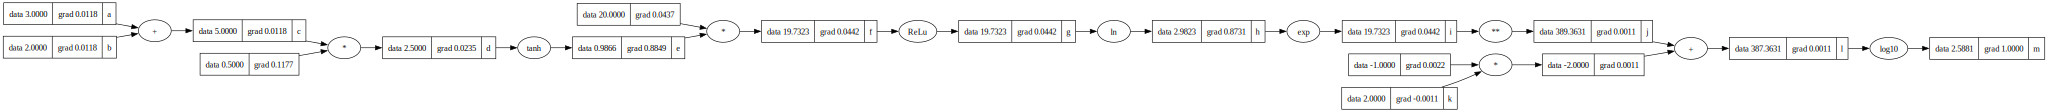

In [80]:
#example for all the operations
a = Scalar(3); a.label = 'a'
b = Scalar(2, label = 'b')
c = a + b; c.label = 'c'
d = c / 2; d.label = 'd'
e = d.tanh(); e.label = 'e'
f = 20 * e; f.label = 'f'
g = f.relu(); g.label = 'g'
h = g.ln(); h.label = 'h'
i = h.exp(); i.label = 'i'
j = i ** 2; j.label = 'j'
k = Scalar(2, label = 'k')
l = j - k; l.label = 'l'
m = l.log10(); m.label = 'm'
m.backprop()

dot = draw_dot(m)
dot

In [102]:
import random
class Neuron:
    def __init__(self, nin):
        self.weights = [Scalar(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Scalar(random.uniform(-1, 1))
class Layer:
    def __init__(self, nin, n):
        self.neurons = [Neuron(nin) for _ in range(n)]
class MLP:
    def __init__(self, nin, n_layer, n_hidden):
        self.layers = [Layer(nin, n_hidden) if l == 0  else Layer(n_hidden, n_hidden) for l in range(n_layer)]

In [ ]:
h = MLP(3, 3, 4)
h.layers[1].neurons[0].weights